# 1. Scraping de Données sur Twitter et Facebook

In [33]:
# VOIR LES FICHIERS SCRIPTS DU DOSSIER 1.scraping

# 2. Prétraitement des Données Textuelles

In [34]:
# Installer les bibliothèques nécessaires
!pip install nltk
!pip install spacy
!pip install pandas


In [35]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Télécharger le modèle de langue français pour spaCy
!python -m spacy download fr_core_news_sm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 51.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [17]:
import pandas as pd
import re
import spacy
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Charger le modèle de langue français avec spaCy
nlp = spacy.load("fr_core_news_sm")

# Charger les stop words
stop_words = set(stopwords.words('french'))
stemmer = SnowballStemmer("french")

# Charger les données
data_df = pd.read_csv("uvbf_combined.csv")  # Remplacer par votre fichier
data_ann_df = pd.read_csv("uvbf_annotated.csv")  # Remplacer par votre fichier

# Supprimer les lignes où 'Texte' est NaN ou non valide
data_df = data_df.dropna(subset=['Texte'])
data_ann_df = data_df.dropna(subset=['Texte'])

# Fonction de nettoyage
def clean_text(text):
    # Vérifier si le texte est une chaîne
    if not isinstance(text, str):
        return ""  # Retourne une chaîne vide pour les valeurs non valides

    # Supprimer les mentions, hashtags, URLs, emojis et caractères non-ASCII
    text = re.sub(r'@\w+|#\w+|https?://\S+|[^\x00-\x7F]+', '', text)

    # Supprimer la ponctuation et les nombres
    text = re.sub(r'[^\w\s]', '', text)  # Supprime la ponctuation
    text = re.sub(r'\d+', '', text)      # Supprime les nombres

    # Transformer le texte en minuscules
    text = text.lower()

    # Tokenisation
    tokens = word_tokenize(text)

    # Suppression des stop words
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatisation avec spaCy
    tokens = [token.lemma_ for token in nlp(" ".join(tokens))]

    return ' '.join(tokens)

# Appliquer le nettoyage au texte
data_df['Texte_nettoye'] = data_df['Texte'].apply(clean_text)

# Sauvegarder le texte nettoyé
data_df.to_csv("uvbf_cleaned.csv", index=False, encoding='utf-8')
print("Le texte a été nettoyé et sauvegardé dans 'uvbf_cleaned.csv'.")


Le texte a été nettoyé et sauvegardé dans 'uvbf_cleaned.csv'.


In [18]:
data_df.isna().sum()
# data_ann_df.isna().sum()

,0
Auteur,0
Texte,0
Date,0
Texte_nettoye,0


In [19]:
data_ann_df.isna().sum()

,0
Auteur,0
Texte,0
Date,0


# 3. Vectorisation des Textes

In [21]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Lire le fichier CSV nettoyé
merged_df = pd.read_csv("uvbf_cleaned.csv", delimiter=',')

# Vérifier les colonnes
print("Colonnes du DataFrame :", merged_df.columns)

# Supprimer les lignes avec des NaN ou des chaînes vides dans la colonne 'Texte_nettoye'
merged_df = merged_df.dropna(subset=['Texte_nettoye'])
merged_df = merged_df[merged_df['Texte_nettoye'].str.strip() != ""]

# Vectorisation des textes nettoyés avec TF-IDF
tfidf_vectorizer = TfidfVectorizer()

# Ajuster et transformer les textes nettoyés en matrice TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(merged_df['Texte_nettoye'])

# Convertir la matrice en DataFrame pour faciliter l'utilisation
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Exporter la matrice TF-IDF vers un fichier CSV
tfidf_df.to_csv("uvbf_tfidf_matrix.csv", index=False, encoding='utf-8')

print("La matrice de vecteurs TF-IDF a été créée et sauvegardée dans 'uvbf_tfidf_matrix.csv'.")


Colonnes du DataFrame : Index(['Auteur', 'Texte', 'Date', 'Texte_nettoye'], dtype='object')
La matrice de vecteurs TF-IDF a été créée et sauvegardée dans 'uvbf_tfidf_matrix.csv'.


# 4. Entraînement d'un Modèle de Classification de Sentiments

### Étape 1 : Charger la Matrice TF-IDF et les Données Annotées

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Charger la matrice TF-IDF et les données annotées
tfidf_df = pd.read_csv("uvbf_tfidf_matrix.csv")
data_labels = pd.read_csv("uvbf_annotated.csv")

tfidf_df = tfidf_df.iloc[:len(data_labels)]
data_labels = data_labels.iloc[:len(tfidf_df)]

# Extraire les labels de sentiment
y = data_labels['Sentiment']

# Justification pour le choix du modèle
# Logistic Regression est choisi ici pour sa bonne performance sur les données vectorisées avec TF-IDF,
# son interprétabilité, et son efficacité sur un volume de données modéré.


### Étape 2 : Diviser les Données et Entraîner le Modèle

In [27]:
# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, y, test_size=0.2, random_state=42)

# Initialiser et entraîner le modèle de Régression Logistique
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

print("Modèle de classification Logistic Regression entraîné.")


Modèle de classification Logistic Regression entraîné.


### Étape 3 : Calculer les Taux Positif et Négatif

In [28]:
# Prédire sur l'ensemble de test
y_pred = model.predict(X_test)

# Afficher le rapport de classification
print(classification_report(y_test, y_pred, target_names=['neutre', 'positif']))

# Calculer les taux positif et négatif dans les prédictions
positive_rate = (y_pred == 'positif').mean() * 100
neutre_rate = (y_pred == 'neutre').mean() * 100

print(f"Taux de commentaires neutre : {positive_rate:.2f}%")
print(f"Taux de commentaires négatifs : {negative_rate:.2f}%")


              precision    recall  f1-score   support

      neutre       0.95      1.00      0.98        61
     positif       0.00      0.00      0.00         3

    accuracy                           0.95        64
   macro avg       0.48      0.50      0.49        64
weighted avg       0.91      0.95      0.93        64

Taux de commentaires neutre : 0.00%
Taux de commentaires négatifs : 0.00%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
### Étape 4 : Sauvegarder le Modèle de Classification

In [29]:
import joblib

# Sauvegarder le modèle de classification entraîné
joblib.dump(model, "sentiment_classification_model.joblib")

print("Modèle de classification sauvegardé dans 'sentiment_classification_model.joblib'.")


Modèle de classification sauvegardé dans 'sentiment_classification_model.joblib'.


# 5. Évaluation du Modèle

Rapport de classification :
              precision    recall  f1-score   support

      neutre       0.95      1.00      0.98        61
     positif       0.00      0.00      0.00         3

    accuracy                           0.95        64
   macro avg       0.48      0.50      0.49        64
weighted avg       0.91      0.95      0.93        64

Taux de commentaires positifs : 0.00%
Taux de commentaires neutres : 100.00%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


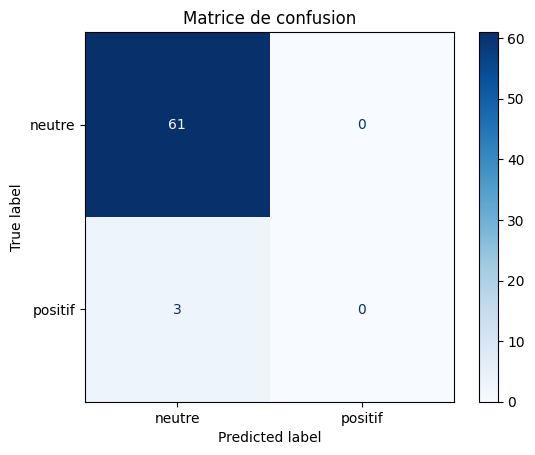

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Prédire les étiquettes sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluation du modèle
print("Rapport de classification :")
print(classification_report(y_test, y_pred, target_names=['neutre', 'positif']))

# Calculer le taux de commentaires positifs et neutres
total_comments = len(y_test)
positive_comments = sum(y_pred == 'positif')
neutral_comments = sum(y_pred == 'neutre')

taux_positif = (positive_comments / total_comments) * 100
taux_neutre = (neutral_comments / total_comments) * 100

print(f"Taux de commentaires positifs : {taux_positif:.2f}%")
print(f"Taux de commentaires neutres : {taux_neutre:.2f}%")

# Générer la matrice de confusion
cm = confusion_matrix(y_test, y_pred, labels=['neutre', 'positif'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neutre', 'positif'])

# Afficher la matrice de confusion
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.show()


# 6. Améliorations et Discussion

In [38]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

# Étape 1 : Chargement des données
data_labels = pd.read_csv('/content/uvbf_annotated.csv')

# Convertir les labels de sentiments en valeurs numériques : positif = 0, neutre = 1
label_mapping = {'positif': 0, 'neutre': 1}
data_labels['label'] = data_labels['Sentiment'].map(label_mapping)

# Étape 2 : Préparation des données pour BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

def encode_data(texts):
    """Encode les textes en utilisant le tokenizer BERT."""
    return tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

# Encodage des textes
X_encoded = encode_data(data_labels['Texte'].tolist())
y_encoded = torch.tensor(data_labels['label'].tolist())

# Division en ensembles d’entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    list(zip(X_encoded['input_ids'], X_encoded['attention_mask'])),
    y_encoded,
    test_size=0.2,
    random_state=42
)

# Classe personnalisée Dataset pour les données encodées
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Préparation des données d’entraînement et de test pour le Trainer
train_encodings = {'input_ids': torch.stack([x[0] for x in X_train]),
                   'attention_mask': torch.stack([x[1] for x in X_train])}
train_labels = y_train

test_encodings = {'input_ids': torch.stack([x[0] for x in X_test]),
                  'attention_mask': torch.stack([x[1] for x in X_test])}
test_labels = y_test

train_dataset = CustomDataset(train_encodings, train_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

# Étape 5 : Configuration des arguments d'entraînement
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    report_to="none"
)

# Étape 6 : Entraînement avec Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Lancer l'entraînement
trainer.train()



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.910800
20,0.771800
30,0.616100
40,0.547400
50,0.385600
60,0.298800
70,0.322000
80,0.201700
90,0.214000


Résultats de l'évaluation :
{'eval_loss': 0.28031158447265625, 'eval_runtime': 119.6056, 'eval_samples_per_second': 0.535, 'eval_steps_per_second': 0.067, 'epoch': 3.0}


('./model/tokenizer_config.json',
 './model/special_tokens_map.json',
 './model/vocab.txt',
 './model/added_tokens.json')

In [45]:
# Étape 7 : Évaluation sur le jeu de test
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

predictions, label_ids, metrics = trainer.predict(test_dataset)

# Calculer les métriques
predicted_labels = predictions.argmax(axis=1)  # Prendre la classe avec la probabilité la plus élevée
accuracy = accuracy_score(label_ids, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(label_ids, predicted_labels, average='weighted')

# Affichage des résultats
print(f"Précision : {accuracy:.2f}")
print(f"Précision (Weighted) : {precision:.2f}")
print(f"Rappel (Weighted) : {recall:.2f}")
print(f"F1-Score (Weighted) : {f1:.2f}")


Précision : 0.92
Précision (Weighted) : 0.85
Rappel (Weighted) : 0.92
F1-Score (Weighted) : 0.88


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
# !zip -r model.zip ./model
# from google.colab import files
# files.download('model.zip')


updating: model/ (stored 0%)
updating: model/config.json (deflated 49%)
updating: model/model.safetensors (deflated 7%)
updating: model/tokenizer_config.json (deflated 75%)
updating: model/vocab.txt (deflated 53%)
updating: model/special_tokens_map.json (deflated 42%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>